Ноутбук с применением pytorch для классификации

In [95]:
libpath = "../scripts"

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(libpath)
from preprocessing import TsfreshDatasetTransformer

from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F


In [139]:
class TorchDataset(Dataset):
    """
    Обертка для взятия данных через pytorch из директорий в структуре tsfresh
    """
    def __init__(self, paths_to_nested: list[str], old_paths: list[str] = None,
                 labels_to_delete: list[str] = None, dict_to_rename: dict[str, str] = None,
                 balanced_classes: bool = False, output_size: int = None):
        self.paths_to_nested = paths_to_nested
        self.old_paths = old_paths
        self.data_getter = TsfreshDatasetTransformer()
        self.list_of_datasets = []
        self.output_size = output_size
        self.adaptive_average_pooling1d = nn.AdaptiveAvgPool1d(self.output_size)
        for path in paths_to_nested:
            self.list_of_datasets.append(
                self.data_getter.make_tsfresh_structure_from_nested_directory(path)
            )
        if old_paths:
            for path in old_paths:
                self.list_of_datasets.append(
                    self.data_getter.make_tsfresh_structure_from_simple_directory(path)
                )
        self.data_hdf5, self.label_hdf5 = self.concat_datasets()
        
        if labels_to_delete:
            self.drop_classes(labels_to_delete)
        if dict_to_rename:
            self.rename_classes(dict_to_rename)
        
        self.data_hdf5["id"] = self.rename_idxs(self.data_hdf5["id"])
        self.data_hdf5.reset_index(drop=True, inplace=True)
        self.label_hdf5.reset_index(drop=True, inplace=True)
        if balanced_classes:
            self.truncate_classes()
        
        self.id_to_label = dict(enumerate(self.label_hdf5.unique()))
        self.label_to_id = {i: j for j, i in self.id_to_label.items()}
        self.indexes = self.label_hdf5.index
    def __getitem__(self, index):
        x = torch.Tensor(self.data_hdf5[self.data_hdf5["id"] == self.indexes[index]]["signal_raw"].to_numpy())
        if self.output_size:
            x = self.transform(x)
        y = self.label_to_id[self.label_hdf5[self.indexes[index]]]
        return x, y
    def __len__(self):
        return len(self.label_hdf5)
    
    def transform(self, x):
        if x.dim() == 1:
            return self.adaptive_average_pooling1d(x[None, :])
        else:
            return self.adaptive_average_pooling1d(x)
    
    def concat_datasets(self):
        # Соединяет несколько датасетов
        concated_dataframe = pd.DataFrame([])
        concated_labels = []
        current_id = 0
        for (data, label) in self.list_of_datasets:
            data_copy = data.copy()
            data_copy["id"] += current_id
            concated_dataframe = pd.concat([concated_dataframe, data_copy], ignore_index=True)
            current_id = concated_dataframe["id"].iloc[-1] +1
            concated_labels.extend(label)
        return concated_dataframe, pd.Series(concated_labels)

    def rename_idxs(self, array):
        # Переименовывает колонку id после удаления метки
        a = array.copy()
        a = np.array(a)
        i = 1
        while i < len(a):
            if a[i] - a[i-1] > 1:
                j = i
                constant = a[j]
                while j < len(a) and a[j] == constant:
                    a[j] = a[i-1] + 1
                    j += 1
                i = j
            else:
                i += 1
        if a[0] > 0:
            a -= a[0]
        return a
    
    def drop_classes(self, labels_to_delete: list[str]):
        mask_drop = self.label_hdf5.isin(labels_to_delete)
        drop_idxs =  self.label_hdf5[mask_drop].index # id of drop labels

        self.data_hdf5.drop(
            index = self.data_hdf5[self.data_hdf5["id"].isin(drop_idxs)].index,
            inplace=True
        )
        self.label_hdf5.drop(
            index = drop_idxs,
            inplace = True
        )
    
    def rename_classes(self, dict_to_rename: dict[str, str]):
        for key, item in dict_to_rename.items():
            self.label_hdf5.replace(key, item, inplace=True)

    def truncate_classes(self):
        idxs_after_truncate = np.array([], dtype=np.uint16) 
        interaction_count = self.label_hdf5.value_counts().min()

        for interaction_name in self.label_hdf5.unique():
            idxs_after_truncate = np.append(idxs_after_truncate, 
                                            self.label_hdf5[self.label_hdf5==interaction_name].
                                            keys().
                                            to_numpy(np.uint16)[:interaction_count])
        idxs_after_truncate.sort()
        self.label_hdf5 = self.label_hdf5.loc[idxs_after_truncate]
        self.data_hdf5 = self.data_hdf5[self.data_hdf5["id"].isin(idxs_after_truncate)]


        

In [140]:
torchDataset = TorchDataset(
    paths_to_nested=["/home/drozdovmk/Projects/ZB/data/data_markup/cesis_nabor_0",
                     "/home/drozdovmk/Projects/ZB/data/data_markup/demostend_0",
                     "/home/drozdovmk/Projects/ZB/data/data_markup/samara_wind",
                     "/home/drozdovmk/Projects/ZB/data/data_markup/Kashira_13may"],
    old_paths=["/home/drozdovmk/Projects/ZB/data/data_markup/hdf5_adaptive"],
    labels_to_delete=["unknown", "hit_series"],
    dict_to_rename={"hit_g" : "hit", "hit_z": "hit"},
    balanced_classes = False,
    output_size=3000
);



Found unknown label in zone 455 
date: 23/12/2024 14:57:52
Found unknown label in zone 737 
date: 24/12/2024 05:47:32
Found unknown label in zone 737 
date: 24/12/2024 05:51:41
Found unknown label in zone 737 
date: 24/12/2024 14:41:29
Found unknown label in zone 737 
date: 24/12/2024 14:41:39
Found unknown label in zone 737 
date: 24/12/2024 06:08:46
Found unknown label in zone 737 
date: 24/12/2024 16:17:34
Found unknown label in zone 737 
date: 24/12/2024 16:17:49
Found unknown label in zone 775 
date: 13/05/2025 11:39:49
Found unknown label in zone 775 
date: 13/05/2025 12:40:28
Found unknown label in zone 775 
date: 13/05/2025 12:40:34
Found unknown label in zone 775 
date: 13/05/2025 12:40:40
Found unknown label in zone 775 
date: 13/05/2025 12:40:52
Found unknown label in zone 610 
date: 13/05/2025 05:57:58
Found unknown label in zone 610 
date: 13/05/2025 14:04:13
Found unknown label in zone 610 
date: 13/05/2025 14:47:01
Found unknown label in zone 610 
date: 13/05/2025 06:05:

In [141]:
train_size = int(0.7 * len(torchDataset))  # 70% под обучение
val_size = int(0.15 * len(torchDataset))   # 15% под валидацию
test_size = len(torchDataset) - train_size - val_size  # остальное под тест

train_dataset, val_dataset, test_dataset = random_split(
    torchDataset, 
    [train_size, val_size, test_size]
)

In [118]:
train_dataloader = DataLoader(train_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=8)

Реализовать модель, которая будет преобразовывать сырой сигнал в
три канала:
1) скользящее среднее
2) скользящее СКО
3) фурье

In [150]:
def sliding_mean(x, window_size):
    l = 0
    r = 1
    ans = torch.zeros_like(x)
    while l < r:
        ans[(l+r)//2] =x[l:r].mean()
        if r < len(x):
            r += 1
        if r - l > window_size or r == len(x):
            l += 1
    return ans
    
def sliding_std(x, window_size):
    l = 0
    r = 1
    ans = torch.zeros_like(x)
    mean = sliding_mean(x, window_size)
    while l < r:
        ans[(l+r)//2] =torch.sqrt(((x[l:r] - mean[l:r])**2).mean())
        if r < len(x):
            r += 1
        if r - l > window_size or r == len(x):
            l += 1
    return ans
    

In [154]:
x = torch.tensor([55.,2,3,4,47,6,7,8])
sliding_std(x, 3)

tensor([ 0.0000, 10.3923, 13.1656, 18.0739, 19.7990, 18.0739,  8.0829,  0.0000])

tensor(2)
tensor(6)
tensor(9)
tensor(14)
tensor(34)


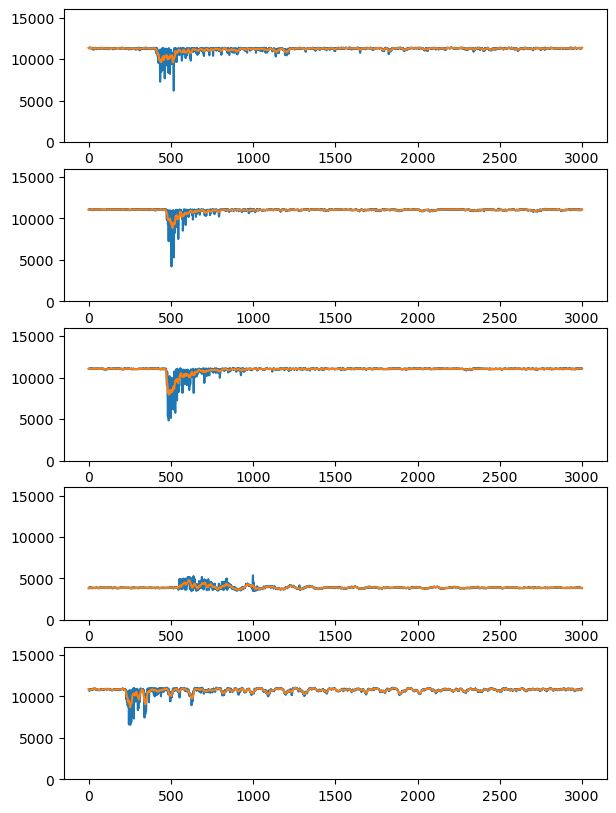

In [151]:
count = 5
j = 0
fig, ax = plt.subplots(count, 1, figsize=(7,10))
for i in torch.randint(0, 1000, size=(1000,)).unique():
    if train_dataset[i][1] ==1:
        print(i)
        x = train_dataset[i][0][0]
        ax[j].plot(x)
        ax[j].plot(sliding_mean(x, 16))
        ax[j].set_ylim([0, 16000])
        j += 1
    if j == count:
        break

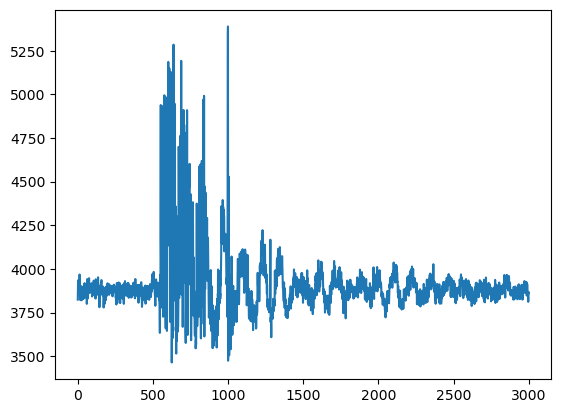

In [147]:
plt.plot(train_dataset[14][0][0])

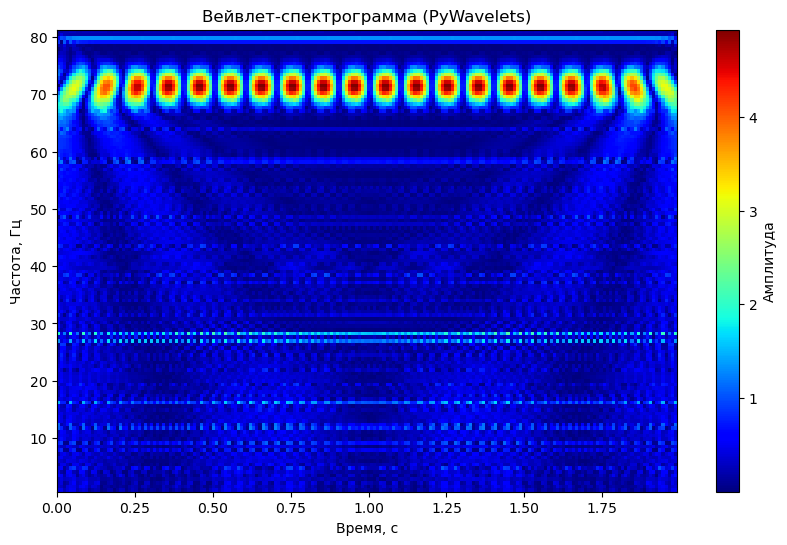

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Создаём тестовый сигнал
dt = 0.01
t = np.arange(0, 2, dt)
f1, f2 = 5, 25
signal = np.sin(2 * np.pi * f1 * t) + np.cos(2 * np.pi * f2 * t)

# Выбираем вейвлет и масштабы (scales)
scales = np.arange(1, 128)
wavelet = 'morl'  # Морле — хороший выбор для спектрограммы

# Вычисляем CWT (непрерывное вейвлет-преобразование)
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

# Рисуем спектрограмму (модуль коэффициентов)
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), 
           extent=[t[0], t[-1], frequencies[-1], frequencies[0]], 
           cmap='jet', aspect='auto')
plt.ylabel('Частота, Гц')
plt.xlabel('Время, c')
plt.title('Вейвлет-спектрограмма (PyWavelets)')
plt.colorbar(label='Амплитуда')
plt.show()